In [31]:
import psutil

mem = psutil.virtual_memory()
print(f"Current memory: {mem.available / 2**20:.2f} MB / {mem.total / 2**20:.2f} MB")

Current memory: 1529.94 MB / 8192.00 MB


Single trading pair EMA crossover strategy


This is an example notebook how to create and run backtests with
[tradeexecutor](https://tradingstrategy.ai/docs/programming/api/execution/index.html) framework.

Some highlights of this notebook:

* The backtest has all its code within a single Jupyter notebook
    - The backtest code and charts are self-contained in a single file
    - The example code is easy to read
    - Easy to test different functionalities of [tradeexecutor](https://tradingstrategy.ai/docs/programming/api/execution/index.html) library
* Runs a backtest for [EMA strategy](https://tradingstrategy.ai/docs/glossary.html#term-EMA) on a single trading pair
    - Uses PancakeSwap on BSC chain for trading
    - Based on fast EMA and slow EMA
    - Depending on the moving average overlap, enters in to a position
* You need a [Trading Strategy API key](https://tradingstrategy.ai/trading-view/backtesting) to run the notebook
* This backtest is made to demostrate the features
    - The strategy may or may not generate any profits, as it is not the purpose of this example


## Set up

Set up the parameters used in in this strategy backtest study.

- Backtested blockchain, exchange and trading pair
- Backtesting period
- Strategy parameters for EMA crossovers

In [32]:
import datetime
import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import StrategyType, TradeRouting, ReserveCurrency

# Tell what trade execution engine version this strategy needs to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE_ENGINE_VERSION = "0.1"

# What kind of strategy we are running.
# This tells we are going to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE = StrategyType.managed_positions

# How our trades are routed.
# PancakeSwap basic routing supports two way trades with BUSD
# and three way trades with BUSD-BNB hop.
TRADE_ROUTING = TradeRouting.pancakeswap_busd

# How often the strategy performs the decide_trades cycle.
# We do it for every 4h.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_1h

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.busd

# Time bucket for our candles
CANDLE_TIME_BUCKET = TimeBucket.h1

# Which chain we are trading
CHAIN_ID = ChainId.bsc

# Which exchange we are trading on.
EXCHANGE_SLUG = "pancakeswap-v2"

# Which trading pair we are trading
TRADING_PAIR = ("ETH", "USDC")

# How much of the cash to put on a single trade
POSITION_SIZE = 0.70

#
# Strategy thinking specific parameter
#

BATCH_SIZE = 90

SLOW_EMA_CANDLE_COUNT = 10     
FAST_EMA_CANDLE_COUNT = 3


# Range of backtesting and synthetic data generation.
# Because we are using synthetic data actual dates do not really matter -
# only the duration

START_AT = datetime.datetime(2021, 6, 1)

END_AT = datetime.datetime(2024, 1,1)

# Start with 10,000 USD
INITIAL_DEPOSIT = 10_000

# If the price drops 0.7% we trigger a stop loss
STOP_LOSS_PCT = 0.993

STOP_LOSS_TIME_BUCKET = TimeBucket.m15


## Strategy logic and trade decisions

- `decide_trades` function decide what trades to take.
- In this example, we calculate two exponential moving averages
(EMAs) and make decisions based on those.

### Indicators

- Note how we also make use of detached and overlayed technical indicators, so that the price chart is not overcrowded


In [33]:
from typing import List, Dict

from pandas_ta.overlap import ema

from tradeexecutor.state.visualisation import PlotKind, RecordingTime
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradingstrategy.universe import Universe
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager

def decide_trades(
        timestamp: pd.Timestamp,
        universe: Universe,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:
    """The brain function to decide the trades on each trading strategy cycle.

    - Reads incoming execution state (positions, past trades)

    - Reads the current universe (candles)

    - Decides what trades to do next, if any, at current timestamp.

    - Outputs strategy thinking for visualisation and debug messages

    :param timestamp:
        The Pandas timestamp object for this cycle. Matches
        TRADING_STRATEGY_CYCLE division.
        Always truncated to the zero seconds and minutes, never a real-time clock.

    :param universe:
        Trading universe that was constructed earlier.

    :param state:
        The current trade execution state.
        Contains current open positions and all previously executed trades, plus output
        for statistics, visualisation and diangnostics of the strategy.

    :param pricing_model:
        Pricing model can tell the buy/sell price of the particular asset at a particular moment.

    :param cycle_debug_data:
        Python dictionary for various debug variables you can read or set, specific to this trade cycle.
        This data is discarded at the end of the trade cycle.

    :return:
        List of trade instructions in the form of :py:class:`TradeExecution` instances.
        The trades can be generated using `position_manager` but strategy could also hand craft its trades.
    """

    # The pair we are trading
    pair = universe.pairs.get_single()

    # How much cash we have in the hand
    cash = state.portfolio.get_current_cash()

    # Get OHLCV candles for our trading pair as Pandas Dataframe.
    # We could have candles for multiple trading pairs in a different strategy,
    # but this strategy only operates on single pair candle.
    # We also limit our sample size to N latest candles to speed up calculations.
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=BATCH_SIZE)

    # We have data for open, high, close, etc.
    # We only operate using candle close values in this strategy.
    close_prices = candles["close"]

    # Calculate exponential moving averages based on slow and fast sample numbers.
    slow_ema_series = ema(close_prices, length=SLOW_EMA_CANDLE_COUNT)
    fast_ema_series = ema(close_prices, length=FAST_EMA_CANDLE_COUNT)

    if slow_ema_series is None or fast_ema_series is None:
        # Cannot calculate EMA, because
        # not enough samples in backtesting
        return []

    if len(slow_ema_series) < 2 or len(fast_ema_series) < 2:
        # We need at least two data points to determine if EMA crossover (or crossunder)
        # occurred at current timestamp. 
        return []

    slow_ema_latest = slow_ema_series.iloc[-1]
    fast_ema_latest = fast_ema_series.iloc[-1]
    price_latest = close_prices.iloc[-1]

    # Compute technical indicators needed for trade decisions.
    slow_ema_crossover = (
        close_prices.iloc[-3] < slow_ema_series.iloc[-2]
        and price_latest > slow_ema_latest
    )
    slow_ema_crossunder = (
        close_prices.iloc[-2] > slow_ema_series.iloc[-2]
        and price_latest < slow_ema_latest
    )
    fast_ema_crossunder = (
        close_prices.iloc[-2] > fast_ema_series.iloc[-2]
        and price_latest < fast_ema_latest
    )

#    entry_price = tradeposition.open_price
#    entry_price = float(get_buy_price['amount'])  
    # position_manager = PositionManager(timestamp, universe, state, pricing_model)
    
    trades = []


    # entry_price = position_manager.get_current_position().get_current_price()
    
    # entry_price = tradeexecutor.analysis.trade_analyser.SpotTrade
    
    # List of any trades we decide on this cycle.
    # trades = []

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, universe, state, pricing_model)

    if not position_manager.is_any_open():
        # No open positions, decide if BUY in this cycle.
        # We buy if we just crossed over the slow EMA or if this is a very first
        # trading cycle and the price is already above the slow EMA.
        if (
            slow_ema_crossunder
            or price_latest < slow_ema_latest and timestamp == START_AT
            ):
            buy_amount = cash * POSITION_SIZE
            new_trades = position_manager.open_1x_long(pair, buy_amount)
            trades.extend(new_trades)
    else:
        # We have an open position, decide if SELL in this cycle.
        # We do that if we fall below any of the two moving averages.
        if slow_ema_crossover or (fast_ema_crossunder and  fast_ema_latest > slow_ema_latest) :
            new_trades = position_manager.close_all()
            assert len(new_trades) == 1
            trades.extend(new_trades)
                
        #else:
        #    current_position = position_manager.get_current_position()
        #    current_price = current_position.get_current_price()
            #if price_latest <= current_price * STOP_LOSS:
            #    print(f"Stop loss. Now {close}, opened at {entry_price}")
            #    new_trades = position_manager.close_all()
            #    assert len(new_trades) == 1
            #    trades.extend(new_trades)
        
    # Visualize strategy
    # See available Plotly colours here
    # https://community.plotly.com/t/plotly-colours-list/11730/3?u=miohtama
    visualisation = state.visualisation

    # plot stop loss line
    if position_manager.is_any_open():
        stop_loss_usd = position_manager.get_current_position().stop_loss
    else:
        stop_loss_usd = None
    visualisation.plot_indicator(timestamp, "stop loss", PlotKind.technical_indicator_on_price, stop_loss_usd, colour="blue", recording_time=RecordingTime.market_time) 
    
    visualisation.plot_indicator(timestamp, "Fast EMA", PlotKind.technical_indicator_detached, fast_ema_latest, colour="red")
    
    visualisation.plot_indicator(timestamp, "Slow EMA", PlotKind.technical_indicator_overlay_on_detached, slow_ema_latest, colour="green", detached_overlay_name="Fast EMA")
    
    # another way to plot horizontal lines
    # allows you to plot as many as you want
    visualisation.plot_indicator(timestamp, "h2", PlotKind.technical_indicator_overlay_on_detached, 3300, colour="orange", detached_overlay_name="Fast EMA")
    
    
    return trades

## Defining the trading universe

We create a trading universe with a single blockchain, exchange and trading pair.
For the sake of easier understanding the code, we name this "Uniswap v2" like exchange with a single ETH-USDC trading pair.

The trading pair contains generated noise-like OHLCV trading data.

In [34]:
from typing import Optional
from tradeexecutor.strategy.trading_strategy_universe import load_pair_data_for_single_exchange, TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradingstrategy.client import Client
import datetime

def create_single_pair_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    dataset = load_pair_data_for_single_exchange(
        client,
        execution_context,
        CANDLE_TIME_BUCKET,
        CHAIN_ID,
        EXCHANGE_SLUG,
        [TRADING_PAIR],
        universe_options,
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
    )

    # Filter down to the single pair we are interested in
    universe = TradingStrategyUniverse.create_single_pair_universe(
        dataset,
        CHAIN_ID,
        EXCHANGE_SLUG,
        TRADING_PAIR[0],
        TRADING_PAIR[1],
    )

    return universe

## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [35]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/alexurbs/.tradingstrategy


## Load data

In [36]:
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions

universe = create_single_pair_trading_universe(
    END_AT,
    client,
    ExecutionContext(mode=ExecutionMode.data_preload),
    UniverseOptions()
)
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

Loading OHLCV data for ETH-USDC:   0%|          | 0/84986415 [00:00<?, ?it/s]

We loaded 22,651 candles.


## Binance Universe

Since it is long only, we set `include_lending=False`

In [37]:
from tradeexecutor.utils.binance import create_binance_universe

binance_universe = create_binance_universe(
    ["ETHUSDT"],
    CANDLE_TIME_BUCKET,
    CANDLE_TIME_BUCKET,
    START_AT - datetime.timedelta(days=BATCH_SIZE + 10),
    END_AT,
    include_lending=False,
    #force_download=True,
)

  0%|          | 0/1 [00:00<?, ?it/s]

## Run backtest with DEX data

Run backtest using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.
- The trade execution engine will download the necessary datasets to run the backtest.
  The datasets may be large, several gigabytes.


In [38]:
import logging

from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, debug_dump = run_backtest_inline(
    name="ETH/USDC fast and slow EMA example",
    start_at=START_AT,
    end_at=END_AT,
    client=client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=universe,
    # create_trading_universe=create_single_pair_trading_universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
    log_level=logging.WARNING,
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/81561600 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 3459 trades


## Run backtest with Binance data

In [39]:
binance_state, binance_universe, binance_debug_dump = run_backtest_inline(
    name="ETH/USDC fast and slow EMA example",
    start_at=START_AT,
    end_at=END_AT,
    client=client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=binance_universe,
    # create_trading_universe=create_single_pair_trading_universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
    log_level=logging.WARNING,
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/81561600 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 3459 trades


## Examine backtest results

Examine `state` that contains all actions the trade executor took.

We plot out a chart that shows
- The price action
- When the strategy made buys or sells

In [40]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 1730
Trades made: 3459


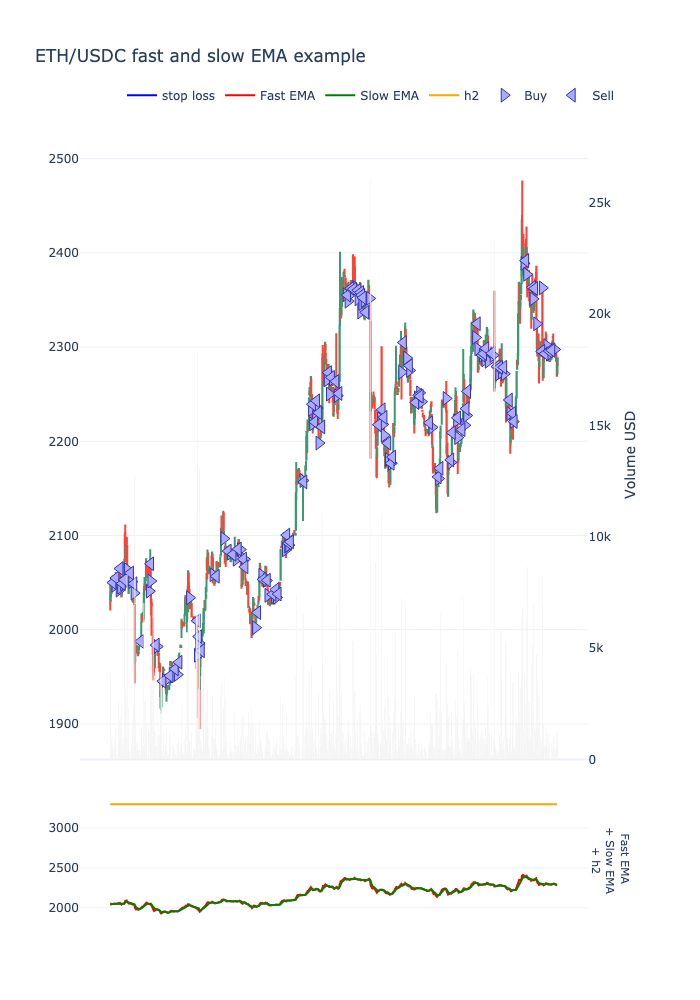

In [47]:

from tradeexecutor.visual.single_pair import visualise_single_pair, visualise_single_pair_positions_with_duration_and_slippage
from tradingstrategy.charting.candle_chart import VolumeBarMode

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    start_at=END_AT - datetime.timedelta(days=50),
    end_at=END_AT,
    height = 1000,
)

figure.show('png')

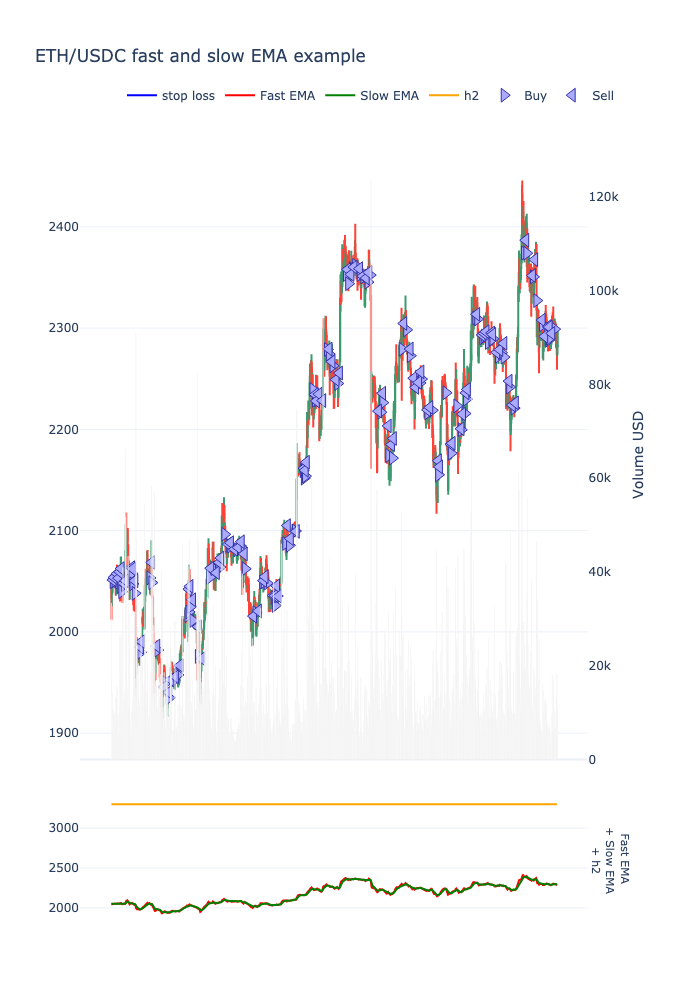

In [49]:
from tradeexecutor.visual.single_pair import visualise_single_pair, visualise_single_pair_positions_with_duration_and_slippage
from tradingstrategy.charting.candle_chart import VolumeBarMode

figure = visualise_single_pair(
    binance_state,
    binance_universe.universe.candles,
    start_at=END_AT - datetime.timedelta(days=50),
    end_at=END_AT,
    height = 1000,
)

figure.show('png')

## Benchmarking the strategy performance

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold the underlying trading pair base asset


In [ ]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=START_AT,
    end_at=END_AT,
    height=800
)

fig.show()

## Benchmarking with Binance data

## Analysing  the strategy success

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [ ]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Strategy summary

Overview of strategy performance



In [ ]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics(state=state)

# with pd.option_context("display.max_row", None):
#      display(summary.to_dataframe())

summary.display()

,
Returns,
Annualised return %,-101.10%
Lifetime return %,-4.47%
Realised PnL,$-447.48
Trade period,16 days 3 hours
,
Holdings,
Total assets,"$9,552.52"
Cash left,"$9,552.52"
Open position value,$0.00


### Position and trade timeline

Display all positions and how much profit they made.

In [ ]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))


Remarks,Opened at,Duration,Exchange,Base asset,Quote asset,Position max value,PnL USD,PnL %,Open mid price USD,Close mid price USD,Trade count,LP fees
,2022-01-01,1 hours,PancakeSwap v2,ETH,USDC,"$7,000.00",$40.99,0.59%,"$3,694.899519","$3,716.533257",2,$35.15
,2022-01-01,2 hours,PancakeSwap v2,ETH,USDC,"$7,028.69",$-22.70,-0.32%,"$3,725.995574","$3,713.964356",2,$35.13
,2022-01-01,3 hours,PancakeSwap v2,ETH,USDC,"$7,012.80",$-2.28,-0.03%,"$3,705.466627","$3,704.259739",2,$35.10
,2022-01-01,2 hours,PancakeSwap v2,ETH,USDC,"$7,011.20",$32.32,0.46%,"$3,711.766057","$3,728.876975",2,$35.18
,2022-01-02,5 hours,PancakeSwap v2,ETH,USDC,"$7,033.83",$20.25,0.29%,"$3,738.208857","$3,748.969659",2,$35.26
,2022-01-02,2 hours,PancakeSwap v2,ETH,USDC,"$7,048.00",$142.30,2.02%,"$3,757.035178","$3,832.888772",2,$35.64
,2022-01-03,4 hours,PancakeSwap v2,ETH,USDC,"$7,147.61",$-17.70,-0.25%,"$3,811.494523","$3,802.056941",2,$35.74
,2022-01-03,2 hours,PancakeSwap v2,ETH,USDC,"$7,135.22",$-23.60,-0.33%,"$3,810.960463","$3,798.354625",2,$35.66
,2022-01-03,2 hours,PancakeSwap v2,ETH,USDC,"$7,118.70",$21.05,0.30%,"$3,815.182796","$3,826.465706",2,$35.69
SL,2022-01-03,1 hours 15 mins,PancakeSwap v2,ETH,USDC,"$7,133.44",$-115.72,-1.62%,"$3,823.753780","$3,761.725034",2,$35.42


## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [ ]:
print("All ok")

All ok
